# data-preprocessing

Preprocessing procedures for raw data. Can be ran as is, with no supervision.

Requires:
1. `data/raw/spb_osm.json.zip`
2. `data/raw/spb_routes.csv`

Produces:
1. `data/preprocessed/infrastructure.json`
2. `data/preprocessed/stops.json`
3. `data/preprocessed/routes.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
import json
from itertools import chain
from typing import Tuple, List, Optional, Set
from zipfile import ZipFile

import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

from myutils.spatial import get_earth_distances
from myutils.json import save_json

from config import raw_osm_data_fpath, raw_routes_data_fpath, \
    infrastructure_fpath, stops_fpath, routes_fpath
from ptn.preprocessing.osm import assign_infrastructure_types

plt.style.use('seaborn-whitegrid')

## OSM

In [3]:
with ZipFile(raw_osm_data_fpath) as zipfile:
    namelist = zipfile.namelist()
    assert len(namelist) == 1
    
    with zipfile.open(namelist[0]) as file:
        spb_osm = pd.DataFrame(json.load(file)['elements'])
        
spb_osm.head(2)

,type,id,lat,lon,tags,nodes,members
0,node,2,59.771793,30.326111,"{'historic': 'memorial', 'image': 'https://upl...",NaN,NaN
1,node,219779,59.842673,30.320486,NaN,NaN,NaN


In [4]:
spb_osm['type'].value_counts()

node        3156034
way          558869
relation      26820
Name: type, dtype: int64

In [5]:
node_coords = spb_osm.loc[spb_osm['type'] == 'node', ['id', 'lat', 'lon']].set_index('id')

assert node_coords.notna().all().all()

node_coords.head(2)

,lat,lon
id,,
2,59.771793,30.326111
219779,59.842673,30.320486


In [6]:
def get_name(tags: dict) -> str:
    if not isinstance(tags, dict):
        return
    
    name = tags.get('official_name', tags.get('name:ru', tags.get('name')))
    
    return name

### Infrastructure objects

In [7]:
mask = spb_osm['tags'].notna()

spb_osm.loc[mask, 'infrastructure_types'] = spb_osm.loc[mask, 'tags'].apply(
    assign_infrastructure_types)

spb_osm['n_infrastructure_types'] = spb_osm['infrastructure_types'].apply(
    lambda l: len(l) if isinstance(l, list) else 0)

spb_osm['n_infrastructure_types'].value_counts()

0    3662869
1      77252
2       1588
3         13
4          1
Name: n_infrastructure_types, dtype: int64

In [8]:
mask = (spb_osm['n_infrastructure_types'] > 0)\
    & (spb_osm['type'] != 'relation')

infrastructure = spb_osm[mask].copy()

infrastructure.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types
0,node,2,59.771793,30.326111,"{'historic': 'memorial', 'image': 'https://upl...",NaN,NaN,[sight_place_tourism],1
492,node,238809,60.189495,29.700196,{'int_name': 'Shoes unknown summer resident (2...,NaN,NaN,[sight_place_tourism],1


In [9]:
infrastructure['name'] = infrastructure['tags'].apply(get_name)

infrastructure.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,name
0,node,2,59.771793,30.326111,"{'historic': 'memorial', 'image': 'https://upl...",NaN,NaN,[sight_place_tourism],1,Центр Круглого Зала (ЦКЗ)
492,node,238809,60.189495,29.700196,{'int_name': 'Shoes unknown summer resident (2...,NaN,NaN,[sight_place_tourism],1,Башмаки неизвестного дачника (2009)


In [10]:
node_ids = set(node_coords.index.tolist())

mask = infrastructure['nodes'].notna()
n_items = mask.sum()

for i, row in tqdm(infrastructure[mask].iterrows(), total=n_items):
    nodes = list(set(row['nodes']).intersection(node_ids))
    coords = node_coords.loc[nodes].values
    
    distances = get_earth_distances(coords, coords)
    diameter = distances.max()
    
    lat, lon = coords.mean(axis=0)
    
    infrastructure.loc[i, 'lat'] = lat
    infrastructure.loc[i, 'lon'] = lon
    infrastructure.loc[i, 'diameter'] = diameter

100%|██████████| 35003/35003 [01:07<00:00, 517.51it/s]


/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/ess_storage/DL_0/lake/ylytkin/Development/.venv/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


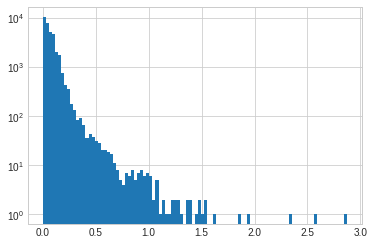

In [11]:
plt.hist(infrastructure['diameter'], bins=100)

plt.yscale('log');

In [12]:
(infrastructure['diameter'] > 0.25).mean()

0.01359328674290555

In [13]:
infrastructure.sort_values(by='diameter', ascending=False).iloc[0]['tags']

{'contact:website': 'http://www.seaport.spb.ru/about/structure/13/',
 'industrial': 'port',
 'landuse': 'industrial',
 'name': 'Первая стивидорная компания',
 'official_name': 'ОАО "Морской порт Санкт-Петербург"',
 'port': 'cargo'}

In [14]:
assert infrastructure[['lat', 'lon']].notna().all().all()
assert infrastructure['id'].nunique() == infrastructure.shape[0]

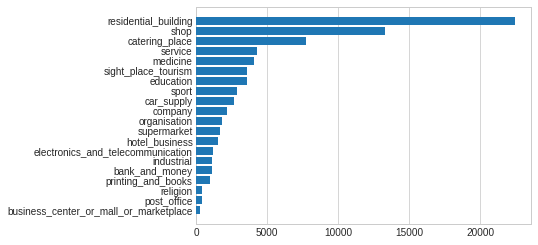

In [15]:
infrastructure_types = pd.Series(chain.from_iterable(infrastructure['infrastructure_types']))
infrastructure_type_counts = infrastructure_types.value_counts().sort_values()

plt.barh(
    infrastructure_type_counts.index,
    infrastructure_type_counts.values,
    zorder=5,
)

plt.grid(axis='y')

In [16]:
infrastructure_json = infrastructure\
    .drop(columns=['type', 'tags', 'nodes', 'members', 'n_infrastructure_types', 'diameter'])\
    .rename(columns={'infrastructure_types': 'types'})

infrastructure_json = [row.to_dict() for _, row in infrastructure_json.iterrows()]

len(infrastructure_json)

75552

In [17]:
save_json(infrastructure_json, infrastructure_fpath)

### Subway stations

In [18]:
def is_subway_entrance(tags: dict) -> bool:
    return isinstance(tags, dict) and tags.get('railway') == 'subway_entrance'


def get_subway_line_color(tags: dict) -> str:
    return tags.get('colour')


spb_osm['is_subway_entrance'] = spb_osm['tags'].apply(is_subway_entrance)

mask = spb_osm['is_subway_entrance'] & (spb_osm['type'] == 'node')
subway_entrances = spb_osm[mask].copy()

subway_entrances['name'] = subway_entrances['tags'].apply(get_name)
subway_entrances['line_color'] = subway_entrances['tags'].apply(get_subway_line_color)

subway_entrances.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,is_subway_entrance,name,line_color
60006,node,268479754,59.966269,30.311449,"{'check_date:opening_hours': '2021-04-04', 'co...",NaN,NaN,[],0,True,Петроградская,blue
74616,node,309943041,59.907268,30.483216,"{'colour': 'orange', 'name': 'Улица Дыбенко', ...",NaN,NaN,[],0,True,Улица Дыбенко,orange


In [19]:
station_names = ['Автово', 'Адмиралтейская', 'Академическая', 'Балтийская',
                 'Беговая', 'Бухарестская', 'Василеостровская', 'Владимирская',
                 'Волковская', 'Выборгская', 'Горьковская', 'Гостиный двор',
                 'Гражданский проспект', 'Достоевская', 'Дунайская', 'Елизаровская',
                 'Звенигородская', 'Звёздная', 'Зенит', 'Кировский завод',
                 'Комендантский проспект', 'Крестовский остров', 'Купчино',
                 'Ладожская', 'Ленинский проспект', 'Лесная', 'Лиговский проспект',
                 'Ломоносовская', 'Маяковская', 'Международная', 'Московская',
                 'Московские ворота', 'Нарвская', 'Невский проспект',
                 'Новочеркасская', 'Обводный канал', 'Обухово', 'Озерки',
                 'Парк Победы', 'Парнас', 'Петроградская', 'Пионерская',
                 'Площадь Александра Невского', 'Площадь Восстания', 'Площадь Ленина',
                 'Площадь Мужества', 'Политехническая', 'Приморская', 'Пролетарская',
                 'Проспект Большевиков', 'Проспект Ветеранов', 'Проспект Просвещения',
                 'Проспект Славы', 'Пушкинская', 'Рыбацкое', 'Садовая',
                 'Сенная площадь', 'Спасская', 'Спортивная', 'Старая Деревня',
                 'Технологический институт', 'Удельная', 'Улица Дыбенко',
                 'Фрунзенская', 'Чернышевская', 'Чкаловская', 'Чёрная речка',
                 'Шушары', 'Электросила']


def get_station_name(entrance_name: str) -> str:
    suitable_station_names = [name for name in station_names if entrance_name.startswith(name)]
    
    if len(suitable_station_names) != 1:
        raise ValueError('multiple or no station names for entrance ' + entrance_name)
        
    return suitable_station_names[0]


subway_entrances['station_name'] = subway_entrances['name'].apply(get_station_name)

subway_entrances.head(2)

,type,id,lat,lon,tags,nodes,members,infrastructure_types,n_infrastructure_types,is_subway_entrance,name,line_color,station_name
60006,node,268479754,59.966269,30.311449,"{'check_date:opening_hours': '2021-04-04', 'co...",NaN,NaN,[],0,True,Петроградская,blue,Петроградская
74616,node,309943041,59.907268,30.483216,"{'colour': 'orange', 'name': 'Улица Дыбенко', ...",NaN,NaN,[],0,True,Улица Дыбенко,orange,Улица Дыбенко


In [20]:
assert subway_entrances['line_color'].notna().all()
assert subway_entrances['station_name'].notna().all()

In [21]:
subway_stations = subway_entrances\
    .groupby(['line_color', 'station_name'])[['lat', 'lon']].mean()\
    .reset_index()\
    .rename(columns={'station_name': 'name'})

subway_stations['name'] = subway_stations['name'] + ' (' + subway_stations['line_color'] + ')'
subway_stations['id'] = subway_stations.index.tolist()
subway_stations['type'] = 'subway'

subway_stations.head(2)

,line_color,name,lat,lon,id,type
0,blue,Горьковская (blue),59.956335,30.318579,0,subway
1,blue,Звёздная (blue),59.833261,30.349021,1,subway


(30.187768395, 30.515850105000002, 59.80753091, 60.07958929)

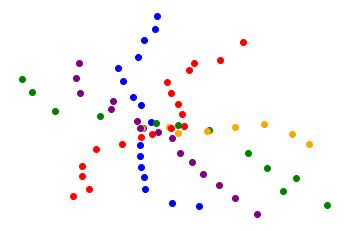

In [22]:
for color in subway_stations['line_color'].unique():
    values = subway_stations\
        .loc[subway_stations['line_color'] == color, ['lon', 'lat']]\
        .values
    
    plt.scatter(*values.T, color=color)
    
plt.axis('off')

### Subway routes

In [23]:
line_starts = {
    'blue': 2,
    'green': 17,
    'orange': 35,
    'purple': 42,
    'red': 57,
}

subway_routes = []

for color in subway_stations['line_color'].unique():
    line_stations = subway_stations[subway_stations['line_color'] == color]
    n_stations = line_stations.shape[0]
    
    coords = line_stations[['lat', 'lon']].values
    distances = get_earth_distances(coords, coords)
    distances[np.arange(n_stations), np.arange(n_stations)] = np.infty
    distances = pd.DataFrame(distances, index=line_stations['id'], columns=line_stations['id'])
    
    start = line_starts[color]
    route = [start]
        
    while True:
        closest_unvisited = distances\
            .loc[route[-1], ~distances.index.isin(route)]\
            .sort_values()
        
        if closest_unvisited.empty:
            break
        
        next_ = closest_unvisited.index[0]
        route.append(next_)
        
    name = color.capitalize() + ' line'
        
    subway_routes.append({
        'name': name,
        'type': 'subway',
        'direction': 1,
        'stops': route,
    })
    subway_routes.append({
        'name': name,
        'type': 'subway',
        'direction': 2,
        'stops': route[::-1],
    })
    
subway_routes = pd.DataFrame(subway_routes)

subway_routes['id'] = subway_routes.index.tolist()

subway_routes.head(2)

,name,type,direction,stops,id
0,Blue line,subway,1,"[2, 1, 3, 7, 16, 4, 14, 12, 5, 0, 9, 15, 10, 1...",0
1,Blue line,subway,2,"[8, 11, 6, 13, 10, 15, 9, 0, 5, 12, 14, 4, 16,...",1


## data.gov.spb.ru

In [24]:
raw_routes = pd.read_csv(raw_routes_data_fpath)

raw_routes = raw_routes.rename(columns={'route_id': 'id', 'route_short_name': 'name',
                                        'transport_type': 'type'})

raw_routes['type'] = raw_routes['type'].map(
    {'Автобус': 'bus', 'Трамвай': 'tram', 'Троллейбус': 'trolley'})

raw_routes['lat'] = raw_routes['coordinates'].apply(lambda x: float(x.split(',')[0]))
raw_routes['lon'] = raw_routes['coordinates'].apply(lambda x: float(x.split(',')[1]))

raw_routes.head(2)

,number,id,name,route_long_name,type,direction,stop_id,next_stop,stop_distance,stop_name,coordinates,lat,lon
0,1,1125,А,Р. Оккервиль - Ул. Коллонтай,tram,1,16396,16367,0.85,"Конечная станция ""Река Оккервиль""","59.9088808952478,30.4946709",59.908881,30.494671
1,2,1125,А,Р. Оккервиль - Ул. Коллонтай,tram,1,16367,16371,0.40,Пр. Солидарности,"59.9118566503083,30.4998817",59.911857,30.499882


In [25]:
stops = raw_routes.drop_duplicates('stop_id')\
    .drop(columns=['id', 'name'])\
    .rename(columns={'stop_id': 'id', 'stop_name': 'name'})\
    .reset_index(drop=True)

stops.head(2)

,number,route_long_name,type,direction,id,next_stop,stop_distance,name,coordinates,lat,lon
0,1,Р. Оккервиль - Ул. Коллонтай,tram,1,16396,16367,0.85,"Конечная станция ""Река Оккервиль""","59.9088808952478,30.4946709",59.908881,30.494671
1,2,Р. Оккервиль - Ул. Коллонтай,tram,1,16367,16371,0.40,Пр. Солидарности,"59.9118566503083,30.4998817",59.911857,30.499882


In [26]:
routes = []

for route_id in raw_routes['id'].unique():
    for direction in raw_routes.loc[raw_routes['id'] == route_id, 'direction'].unique():
        mask = (raw_routes['id'] == route_id) & (raw_routes['direction'] == direction)
        raw_route = raw_routes[mask]
        
        assert raw_route['type'].nunique() == 1
        route_type = raw_route.iloc[0]['type']

        assert raw_route['name'].nunique() == 1
        name = raw_route.iloc[0]['name']
        
        assert raw_route['stop_id'].nunique() == raw_route.shape[0]

        next_stops = raw_route.set_index('stop_id')['next_stop']

        start = set(next_stops.index) - set(next_stops.values)
        
        if (len(start) == 0):
            assert set(next_stops.index) == set(next_stops.values)  # circular route
            
            start = next_stops.index[0]
            route = [start]
            
            while True:
                next_ = next_stops[route[-1]]
                
                if next_ in route:
                    break
                    
                route.append(next_)
        
        else:
            assert len(start) == 1
            start = start.pop()

            route = [start]

            while route[-1] in next_stops.index:
                route.append(next_stops[route[-1]])

        routes.append({
            'name': name,
            'type': route_type,
            'direction': direction,
            'stops': route,
            'id': route_id,
        })
        
routes = pd.DataFrame(routes)

routes.head(2)

,name,type,direction,stops,id
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125


In [27]:
route_stops = set(chain.from_iterable(routes['stops']))
stops_ = set(stops['id'].unique())

missing_stops = route_stops - stops_

len(missing_stops)

45

In [28]:
def remove_missing_stops(route: List[int]) -> List[int]:
    missing = set(route).intersection(missing_stops)
    
    if len(missing) == 0:
        return route
    
    assert len(missing) == 1
    missing = missing.pop()
    assert route.index(missing) == len(route) - 1
    
    return route[:-1]


routes['stops'] = routes['stops'].apply(remove_missing_stops)

routes.head(2)

,name,type,direction,stops,id
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125


## All stops and routes together

In [29]:
all_stops = stops.append(subway_stations, ignore_index=True)\
    .drop(columns=['number', 'route_long_name', 'next_stop', 'direction',
                   'stop_distance', 'coordinates', 'line_color'])

all_stops.head(2)

,type,id,name,lat,lon
0,tram,16396,"Конечная станция ""Река Оккервиль""",59.908881,30.494671
1,tram,16367,Пр. Солидарности,59.911857,30.499882


In [30]:
assert all_stops.notna().all().all()
assert all_stops['id'].nunique() == all_stops.shape[0]

In [31]:
all_routes = routes.append(subway_routes, ignore_index=True)

all_routes['stops'] = all_routes['stops'].apply(lambda l: [int(i) for i in l])

all_routes.head(2)

,name,type,direction,stops,id
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125


In [32]:
stop2id = {stop: i for i, stop in all_stops['id'].iteritems()}

coords = all_stops[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    i = [stop2id[stop] for stop in route]
    distance = distances[i[:-1], i[1:]].sum()
    
    return distance


all_routes['distance'] = all_routes['stops'].apply(get_route_distance)

all_routes.head(2)

,name,type,direction,stops,id,distance
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",1125,3.826103


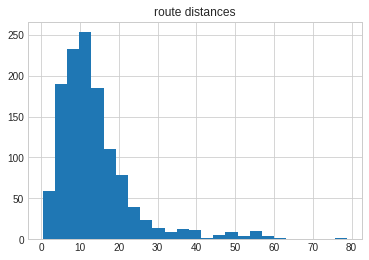

In [33]:
all_routes['distance'].hist(bins=25)
plt.title('route distances');

In [34]:
assert all_routes.notna().all().all()
assert not all_routes.duplicated(['id', 'direction']).any()

In [35]:
route_stops = set(chain.from_iterable(all_routes['stops']))
stops_ = set(all_stops['id'].unique())

missing_stops = route_stops - stops_

assert len(missing_stops) == 0

In [36]:
all_stops_json = [row.to_dict() for _, row in all_stops.iterrows()]

len(all_stops_json)

7660

In [37]:
save_json(all_stops_json, stops_fpath)

In [38]:
all_routes_json = [row.to_dict() for _, row in all_routes.iterrows()]

len(all_routes_json)

1253

In [39]:
save_json(all_routes_json, routes_fpath)